In [5]:
# --- 1. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from sklearn.ensemble import RandomForestRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

In [6]:
# --- 2. Data Loading ---
df = pd.read_csv(r"C:\Users\brije\Downloads\P587 DATASET.csv", index_col='Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.sort_index(inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,58.485714,58.928570,58.428570,58.747143,75555200
2012-01-04,58.571430,59.240002,58.468571,59.062859,65005500
2012-01-05,59.278572,59.792858,58.952858,59.718571,67817400
2012-01-06,59.967144,60.392857,59.888573,60.342857,79573200
2012-01-09,60.785713,61.107143,60.192856,60.247143,98506100


Basic Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2011 entries, 2012-01-03 to 2019-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2011 non-null   float64
 1   High    2011 non-null   float64
 2   Low     2011 non-null   float64
 3   Close   2011 non-null   float64
 4   Volume  2011 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 94.3 KB
None

Descriptive Stats:
              Open         High          Low        Close        Volume
count  2011.000000  2011.000000  2011.000000  2011.000000  2.011000e+03
mean    126.707469   127.827594   125.580258   126.741235  5.949670e+07
std      50.483753    50.926301    50.124940    50.578369  4.683856e+07
min      55.424286    57.085712    55.014286    55.790001  1.136200e+07
25%      85.882858    86.717858    85.056427    86.202145  2.758565e+07
50%     113.050003   114.190002   111.870003   113.050003  4.346900e+07
75%     165.190002   167.

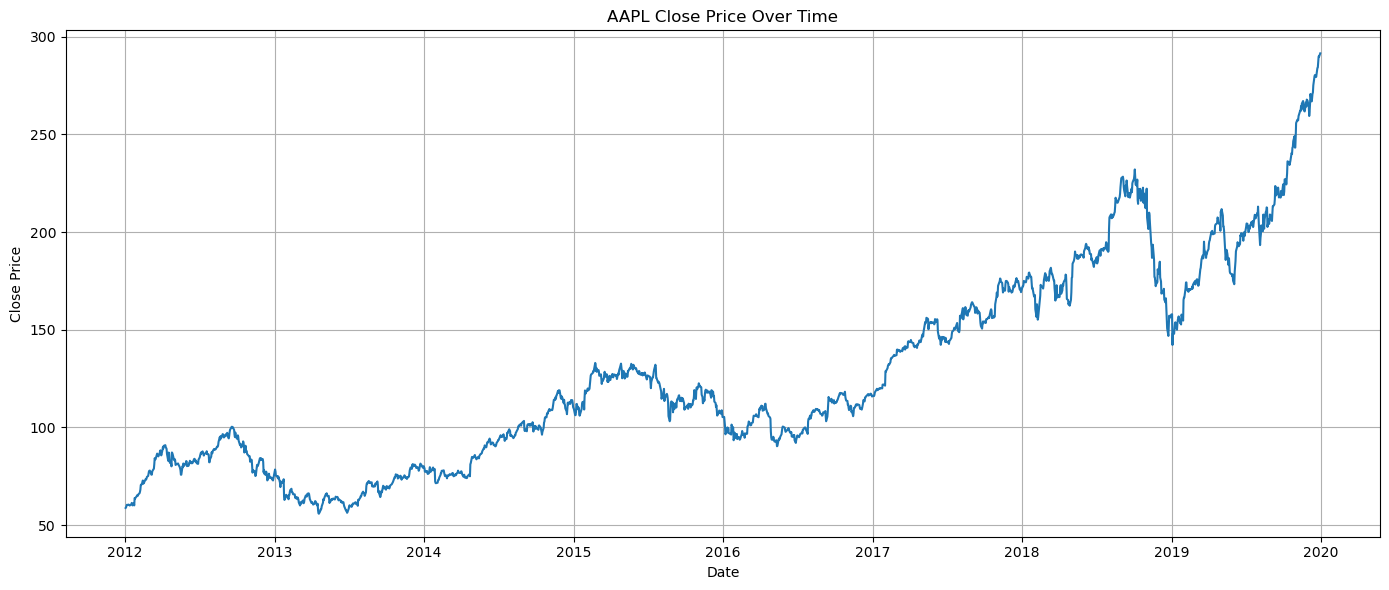

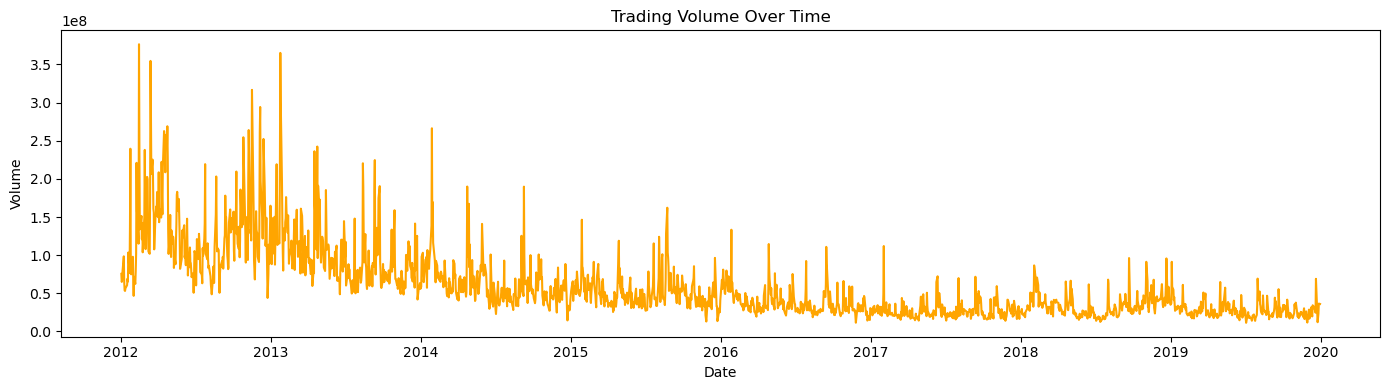

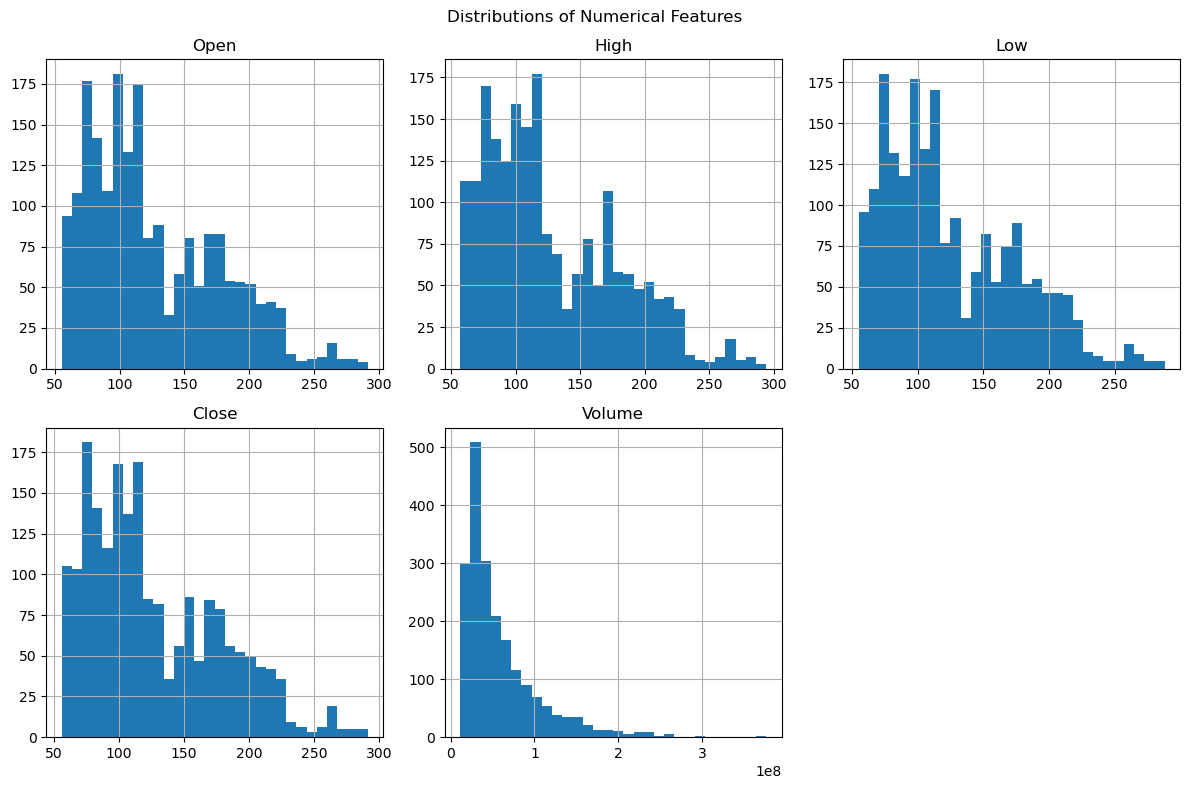

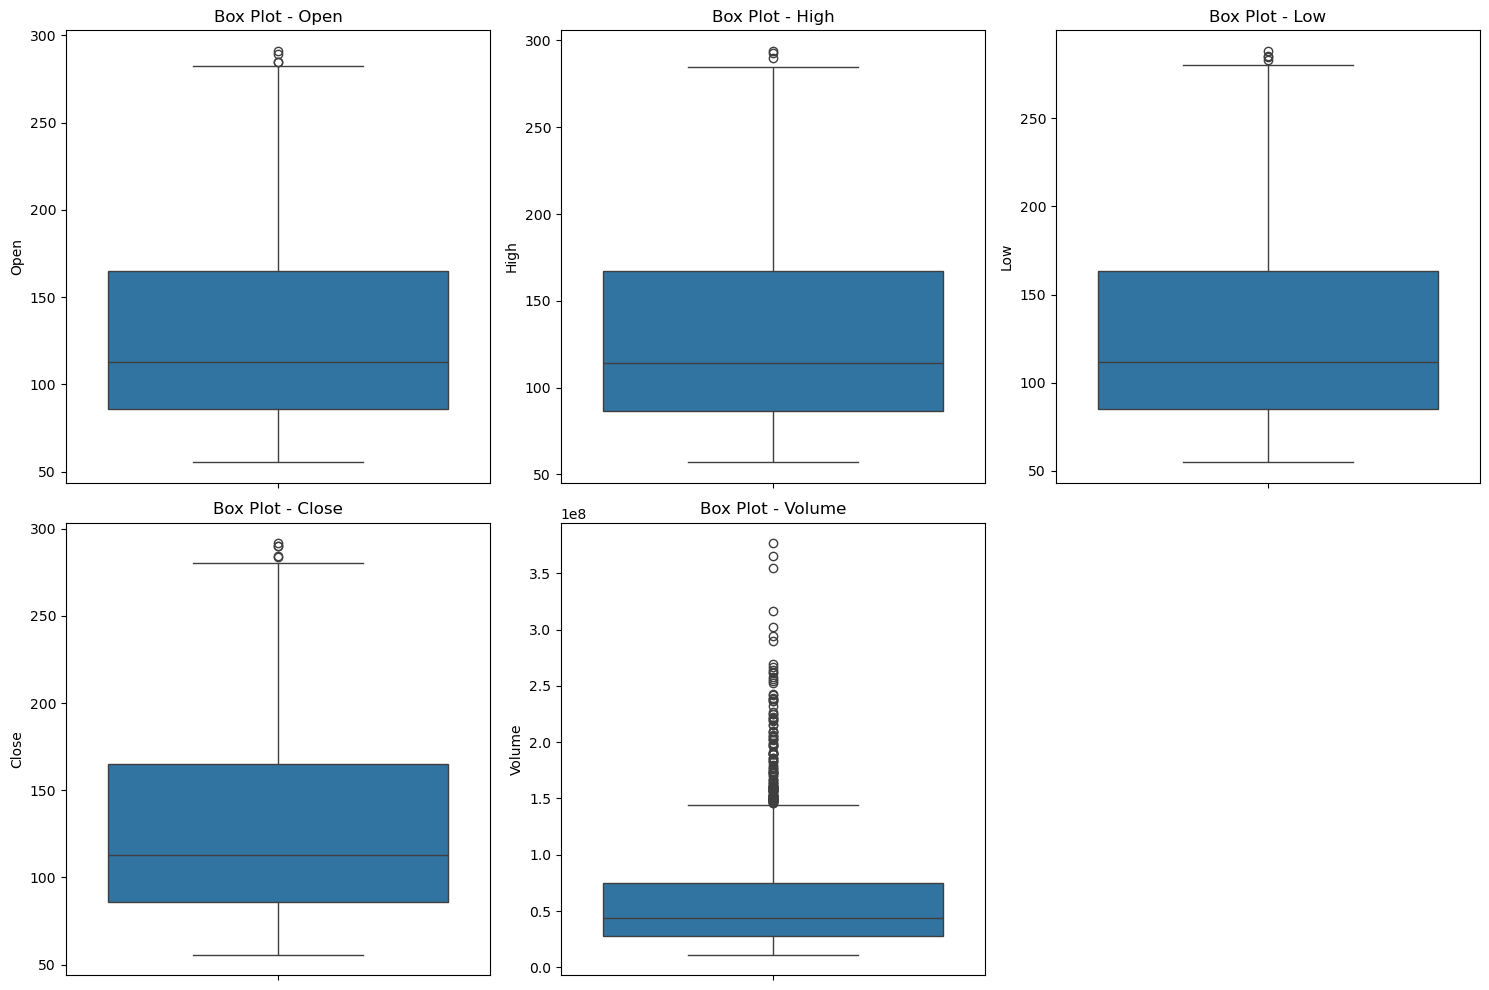

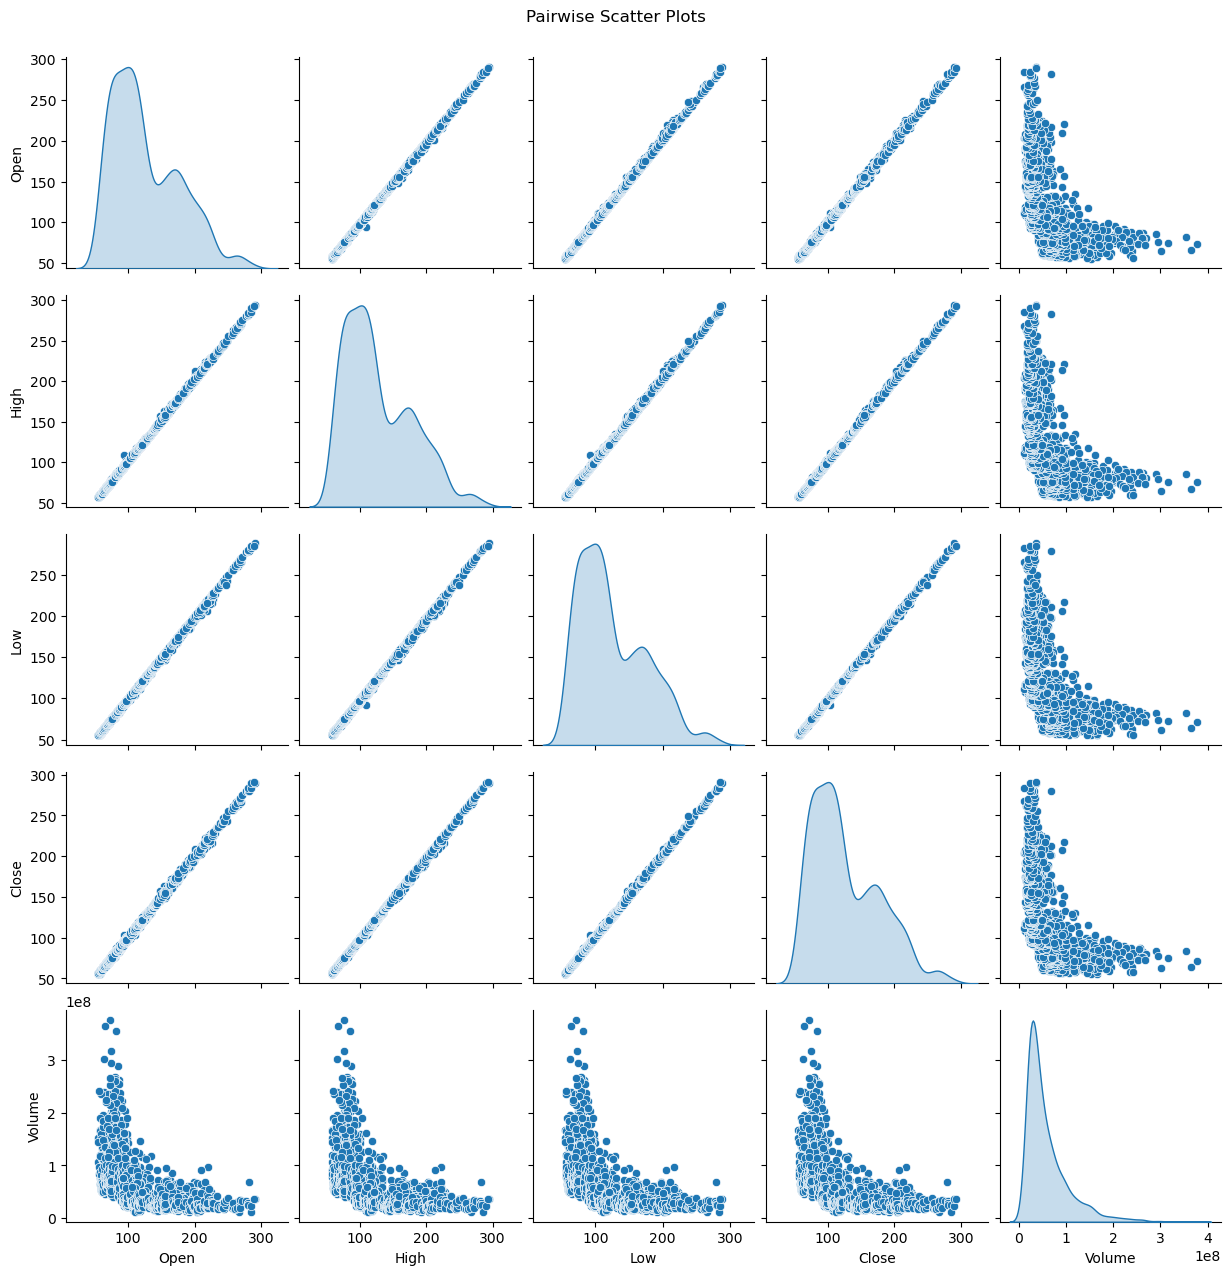

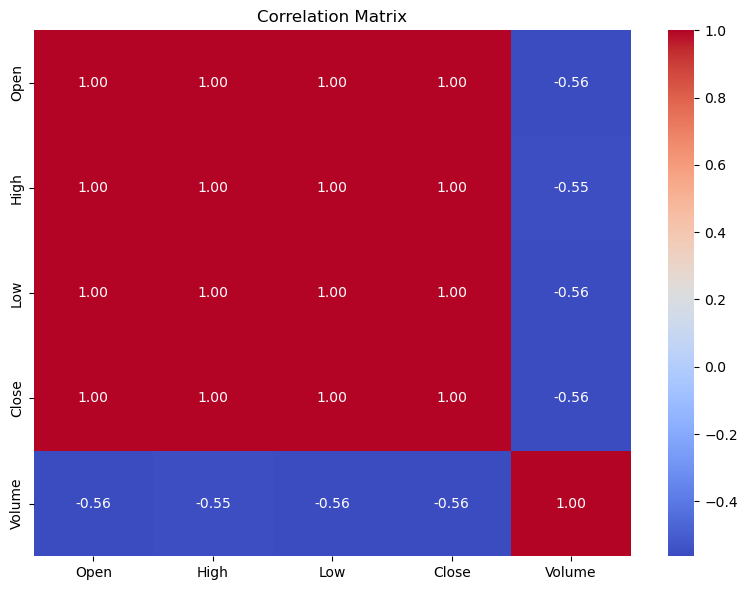

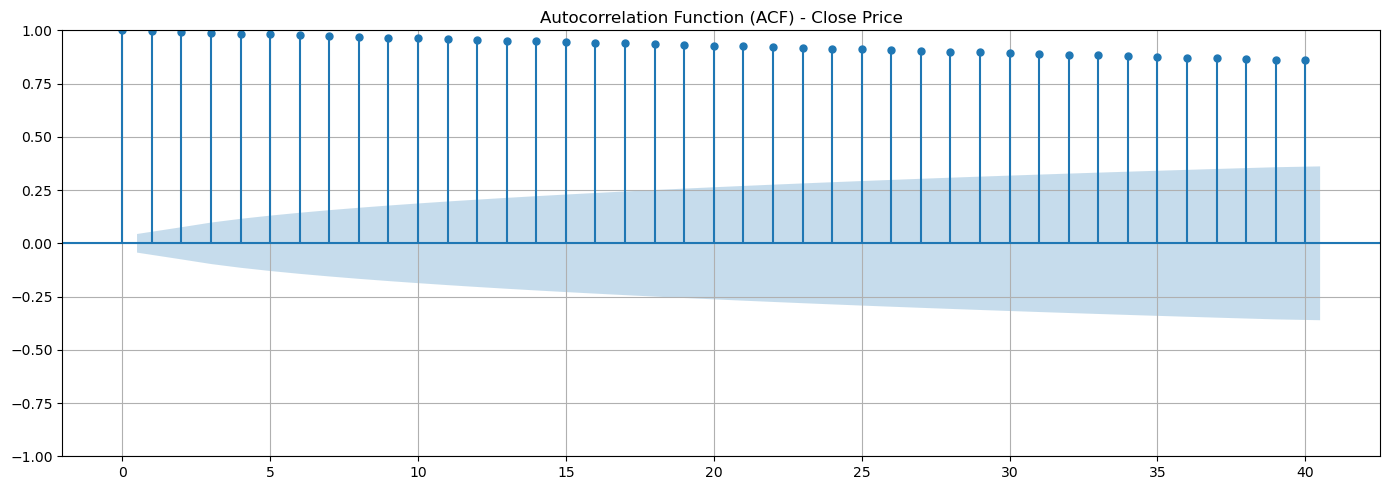

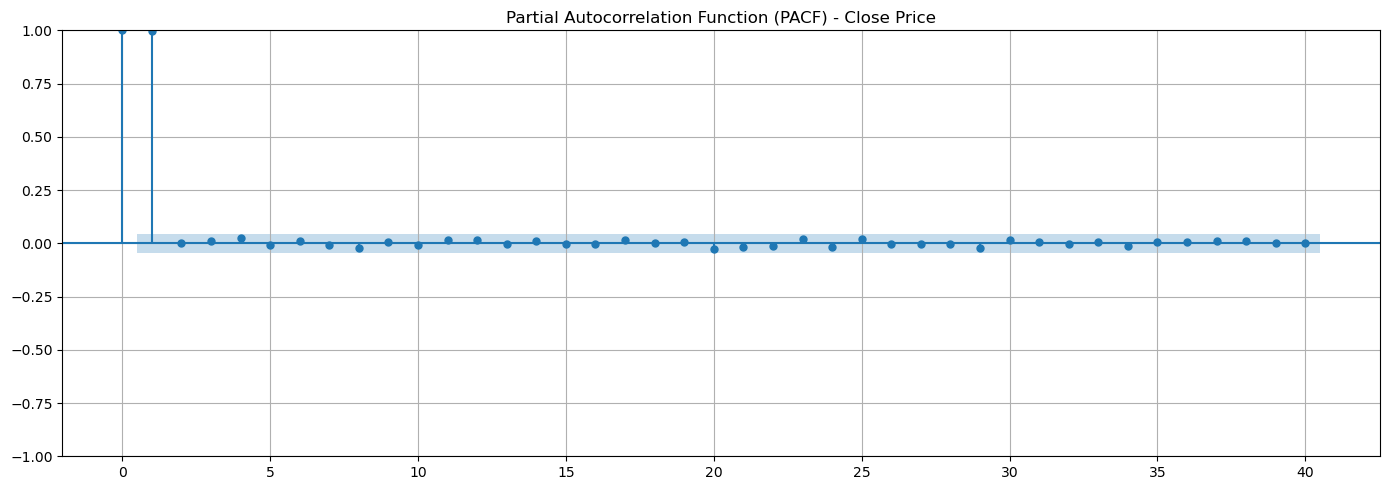

In [7]:
# --- 3.1 EDA ---

print("Basic Info:")
print(df.info())

print("\nDescriptive Stats:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

# --- Line Plot of Close ---
plt.figure(figsize=(14, 6))
plt.plot(df['Close'])
plt.title("AAPL Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Volume Plot ---
plt.figure(figsize=(14, 4))
plt.plot(df['Volume'], color='orange')
plt.title("Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()

# --- Distribution Plots ---
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df[numeric_cols].hist(bins=30, figsize=(12, 8), layout=(2, 3))
plt.suptitle("Distributions of Numerical Features")
plt.tight_layout()
plt.show()

# --- Box Plots ---
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f"Box Plot - {col}")
    plt.tight_layout()
plt.show()

# --- Scatter Matrix / Pairplot ---
sns.pairplot(df[numeric_cols], diag_kind='kde')
plt.suptitle("Pairwise Scatter Plots", y=1.02)
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# --- ACF and PACF Plots for Close Price ---
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 5))
plot_acf(df['Close'], lags=40, ax=plt.gca())
plt.title("Autocorrelation Function (ACF) - Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plot_pacf(df['Close'], lags=40, ax=plt.gca(), method='ywm')
plt.title("Partial Autocorrelation Function (PACF) - Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
df1=pd.read_csv(r"C:\Users\brije\Downloads\P587 DATASET.csv")
df1['MA7'] = df1['Close'].rolling(window=7).mean()
df1['MA30'] = df1['Close'].rolling(window=30).mean()
df1['Returns'] = df1['Close'].pct_change()
df1['Volatility'] = df1['Returns'].rolling(window=7).std()
df1.fillna(0, inplace=True)

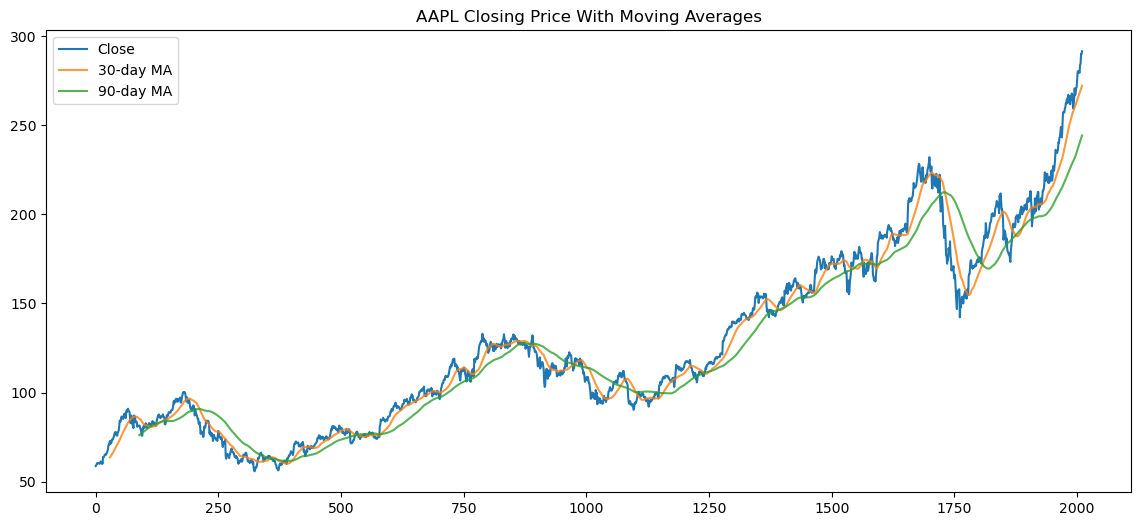

In [10]:
   # Plot Moving Averages for Trend Smoothing*****
plt.figure(figsize=(14,6))
plt.plot(df1['Close'], label='Close')
plt.plot(df1['Close'].rolling(window=30).mean(), label='30-day MA', alpha=0.8)
plt.plot(df1['Close'].rolling(window=90).mean(), label='90-day MA', alpha=0.8)
plt.title("AAPL Closing Price With Moving Averages")
plt.legend()
plt.show()


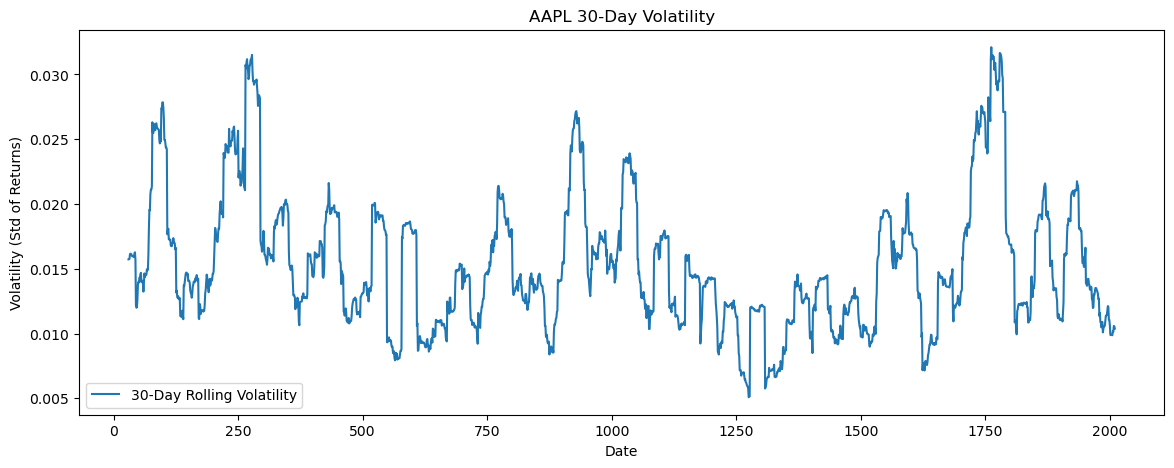

In [11]:
     #Volatility Analysis*****

df1['Return'] = df1['Close'].pct_change()
df1['Volatility_30'] = df1['Return'].rolling(window=30).std()

plt.figure(figsize=(14,5))
plt.plot(df1['Volatility_30'], label='30-Day Rolling Volatility')
plt.title("AAPL 30-Day Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility (Std of Returns)")
plt.legend()
plt.show()




In [12]:
# --- 3.2 Outlier Handling ---
def cap_outliers(series, method='zscore', threshold=3):
    if method == 'zscore':
        mean, std = series.mean(), series.std()
        return series.clip(lower=mean - threshold*std, upper=mean + threshold*std)
    elif method == 'iqr':
        Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
        IQR = Q3 - Q1
        return series.clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)

for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    method = 'zscore' if col == 'Close' else 'iqr'
    df[col] = cap_outliers(df[col], method)

In [13]:
# --- 4. Feature Engineering ---
prediction_horizon = 30
df['Target'] = df['Close'].shift(-prediction_horizon)
df['Close_Lag_30'] = df['Close'].shift(prediction_horizon)
df['Daily_Return'] = df['Close'].pct_change() * 100
df.dropna(inplace=True)

X = df.drop(columns=['Target', 'Close'])
y = df['Target']


In [14]:
# --- 5. Train-Test Split ---
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [15]:
# --- 6. Scaling ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), columns=X.columns, index=X_test.index)

y_train_scaled = pd.Series(scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten(), index=y_train.index)
y_test_scaled = pd.Series(scaler_y.transform(y_test.values.reshape(-1, 1)).flatten(), index=y_test.index)


In [16]:
# --- 7. ARIMA Model ---
train_close = df['Close'].iloc[:train_size]
test_close = df['Close'].iloc[train_size:]

arima_model = auto_arima(train_close, seasonal=False, trace=False, stepwise=True)
arima_preds = arima_model.predict(n_periods=len(test_close))
arima_rmse = np.sqrt(mean_squared_error(test_close, arima_preds))

In [17]:
# --- 8. SARIMAX Model ---
sarimax_model = SARIMAX(train_close, exog=X_train_scaled ,order=arima_model.order)
sarimax_result = sarimax_model.fit(disp=False)
sarimax_preds = sarimax_result.forecast(steps=len(test_close), exog=X_test_scaled)
sarimax_rmse = np.sqrt(mean_squared_error(test_close, sarimax_preds))

In [18]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Prepare supervised dataset using a 30-day lookback window
# Each sample uses 30 previous closing prices to predict the next day's close
# Split data into 90% training and 10% testing sets


lookback = 30
X_ml, y_ml = [], []
close_vals = df['Close'].values
for i in range(len(close_vals) - lookback):
    X_ml.append(close_vals[i:i+lookback])
    y_ml.append(close_vals[i+lookback])
X_ml, y_ml = np.array(X_ml), np.array(y_ml)
split_ml = int(0.80 * len(X_ml))
X_train_ml, X_test_ml = X_ml[:split_ml], X_ml[split_ml:]
y_train_ml, y_test_ml = y_ml[:split_ml], y_ml[split_ml:]


# Train XGBoost Regressor (gradient boosting model)
# Predict on test data and calculate RMSE for performance evaluation
# XGBoost Model

xgb_model = XGBRegressor(n_estimators=100)
xgb_model.fit(X_train_ml, y_train_ml)
xgb_pred = xgb_model.predict(X_test_ml)
xgb_rmse = np.sqrt(mean_squared_error(y_test_ml, xgb_pred))
print("XGBoost RMSE:", xgb_rmse)


# Train Random Forest Regressor (ensemble of decision trees)
# Predict on test data and compute RMSE
# Compare RMSE values to determine which model performs better

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_ml, y_train_ml)
rf_pred = rf_model.predict(X_test_ml)
rf_rmse = np.sqrt(mean_squared_error(y_test_ml, rf_pred))
print("Random Forest RMSE:", rf_rmse)

XGBoost RMSE: 31.532099749521645
Random Forest RMSE: 29.661253345628126



📊 ARIMA Evaluation Metrics:
RMSE: 33.3176
MAE:  28.0282
R²:   -1.0083

📊 SARIMAX Evaluation Metrics:
RMSE: 1.0568
MAE:  0.8027
R²:   0.9980

📊 XGBoost Evaluation Metrics:
RMSE: 31.5321
MAE:  24.6247
R²:   -0.7989

📊 Random Forest Evaluation Metrics:
RMSE: 29.6613
MAE:  22.6478
R²:   -0.5918


,Model,RMSE,MAE,R2
0,ARIMA,33.317643,28.028168,-1.008312
1,SARIMAX,1.056802,0.802736,0.997979
2,XGBoost,31.532100,24.624706,-0.798906
3,Random Forest,29.661253,22.647844,-0.591775


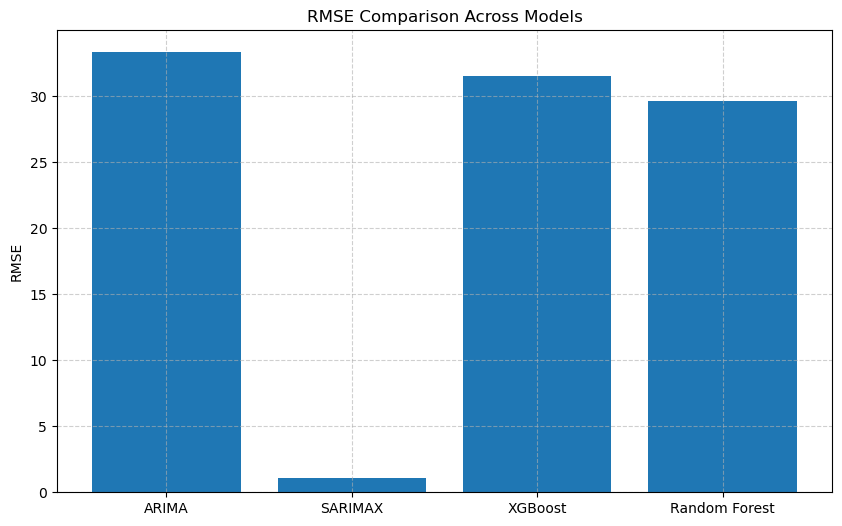

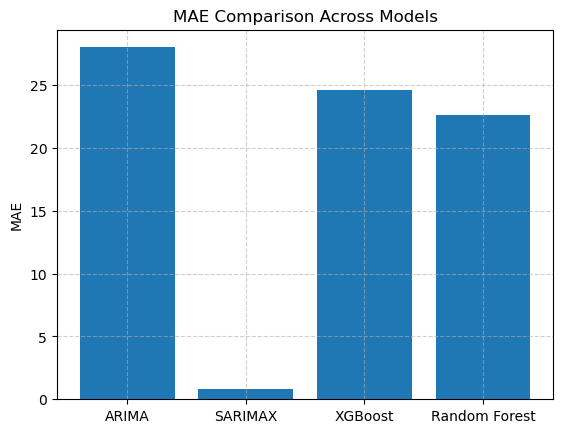

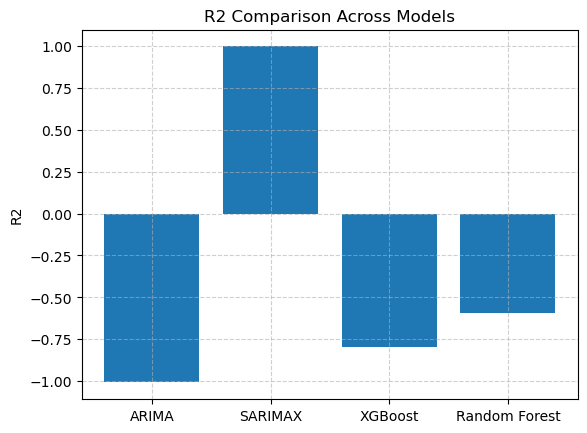

In [19]:
# --- 10.1 Model Evaluation ---
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {model_name} Evaluation Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate all models
eval_arima = evaluate_model(test_close, arima_preds, "ARIMA")
eval_sarimax = evaluate_model(test_close, sarimax_preds, "SARIMAX")
eval_xgboost = evaluate_model(y_test_ml, xgb_pred, "XGBoost")
eval_rf = evaluate_model(y_test_ml, rf_pred, "Random Forest")   

# Combine results
evaluation_df = pd.DataFrame([eval_arima, eval_sarimax, eval_xgboost, eval_rf])  
display(evaluation_df)

# Visualization stays SAME
# --- Visualization: Comparison ---
plt.figure(figsize=(10, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.bar(evaluation_df['Model'], evaluation_df[metric], label=metric)
    plt.title(f"{metric} Comparison Across Models")
    plt.ylabel(metric)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [20]:
# --- 10.2 Compare Models ---
results = {
    "ARIMA": arima_rmse,
    "SARIMAX": sarimax_rmse,
    "XGBoost": xgb_rmse,
    "Random Forest": rf_rmse    
}

# Find best model
best_model_name = min(results, key=results.get)
best_model = {
    'ARIMA': arima_model,
    'SARIMAX': sarimax_result,
    'XGBoost': xgb_model,
    'Random Forest': rf_model    
}[best_model_name]

print(f"\n✅ Best Performing Model: {best_model_name} with RMSE = {results[best_model_name]:.4f}")



✅ Best Performing Model: SARIMAX with RMSE = 1.0568


In [21]:
# --- 11. Save Best Model & Scalers ---
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")
joblib.dump(scaler_X, "scaler_X_sarimax.pkl")



['scaler_X_sarimax.pkl']

In [22]:
# --- 12. Generate Future Exogenous Variables (Smoothed Simulation) ---
n_future = prediction_horizon
recent = df.iloc[-30:][['Open', 'High', 'Low', 'Volume', 'Close']]

def smooth_noise(mean, std, steps=30, window=3):
    raw = np.random.normal(mean, std, steps + window)
    return pd.Series(raw).rolling(window, min_periods=1).mean().iloc[-steps:].values

sim_open = smooth_noise(recent['Open'].mean(), recent['Open'].std(), n_future)
sim_high = smooth_noise(recent['High'].mean(), recent['High'].std(), n_future)
sim_low = smooth_noise(recent['Low'].mean(), recent['Low'].std(), n_future)
sim_volume = smooth_noise(recent['Volume'].mean(), recent['Volume'].std(), n_future)
sim_close_lag_30 = np.linspace(df['Close'].iloc[-1], df['Close'].iloc[-1] * 1.02, n_future)
sim_daily_return = np.random.normal(0, 0.05, n_future)

future_exog = pd.DataFrame({
    'Open': sim_open,
    'High': sim_high,
    'Low': sim_low,
    'Volume': sim_volume,
    'Close_Lag_30': sim_close_lag_30,
    'Daily_Return': sim_daily_return
})
future_exog_scaled = pd.DataFrame(scaler_X.transform(future_exog), columns=X.columns)




In [23]:
# --- 13. Forecast Using Best Model ---
if best_model_name == "SARIMAX":
    future_preds = sarimax_result.forecast(steps=n_future, exog=future_exog_scaled)

elif best_model_name == "XGBoost":
    future_preds = xgb_model.predict(future_exog_scaled)

elif best_model_name == "Random Forest":
    future_preds = rf_model.predict(future_exog_scaled)

else:  # Default to ARIMA
    future_preds = arima_model.predict(n_periods=n_future)


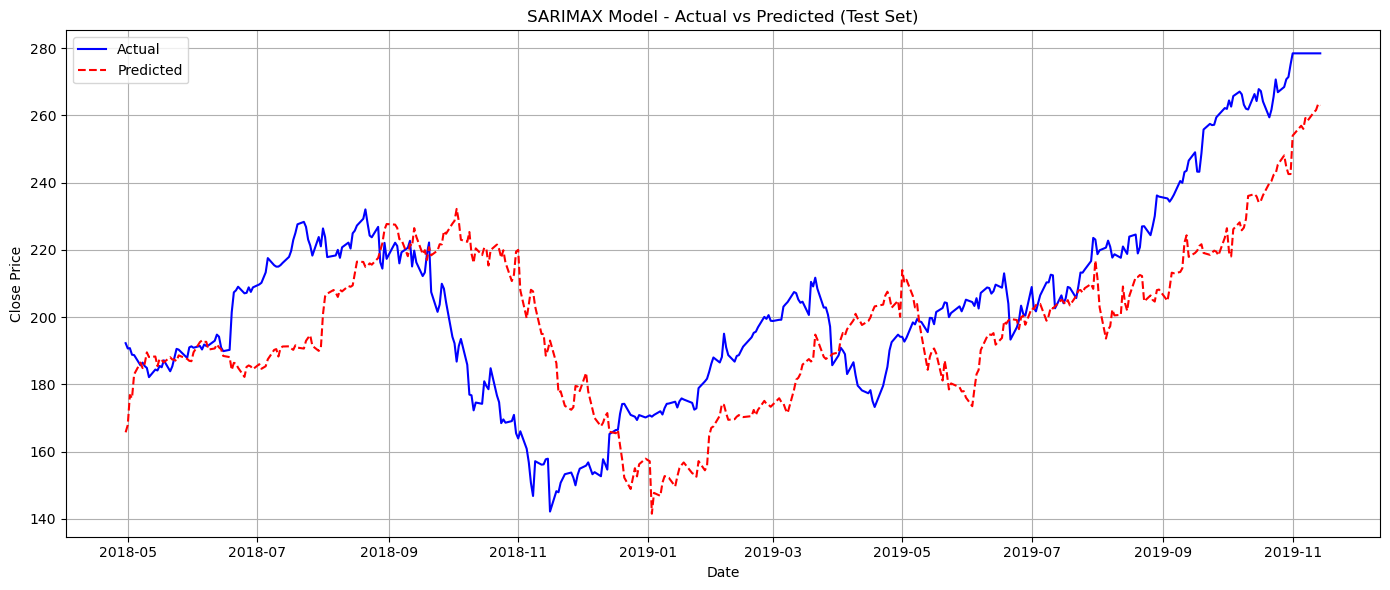

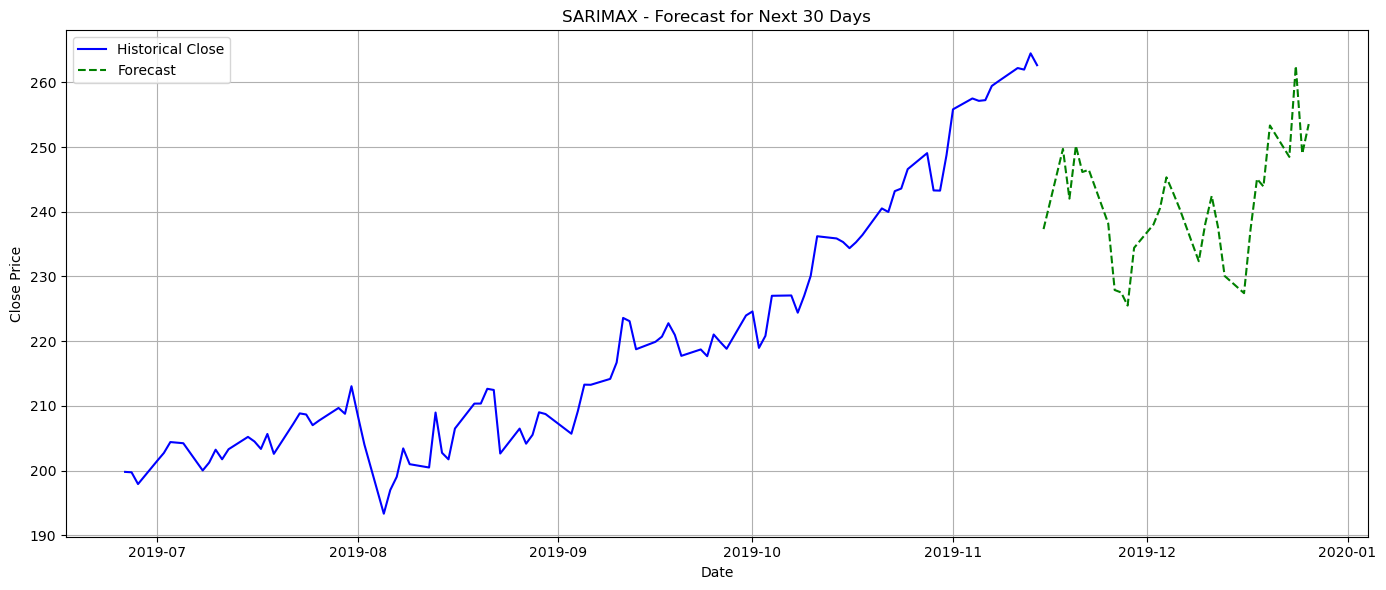

In [24]:
# --- 14.1 Original vs Predicted on Test Set (Historical Evaluation) ---
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
if best_model_name == "XGBoost":
    plt.plot(y_test_ml.index, xgb_pred, label='Predicted', color='red', linestyle='--')
elif best_model_name == "Random Forest":
    plt.plot(y_test_ml.index, rf_pred, label='Predicted', color='red', linestyle='--')
elif best_model_name == "SARIMAX":
    plt.plot(test_close.index, sarimax_preds, label='Predicted', color='red', linestyle='--')
else:
    plt.plot(test_close.index, arima_preds, label='Predicted', color='red', linestyle='--')

plt.title(f"{best_model_name} Model - Actual vs Predicted (Test Set)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 14.2 Extended Forecast Plot with Historical Context ---
plt.figure(figsize=(14, 6))
plt.plot(df.index[-100:], df['Close'].iloc[-100:], label='Historical Close', color='blue')
future_dates = pd.date_range(df.index[-1], periods=n_future+1, freq='B')[1:]
plt.plot(future_dates, future_preds, label='Forecast', color='green', linestyle='--')

plt.title(f"{best_model_name} - Forecast for Next {n_future} Days")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

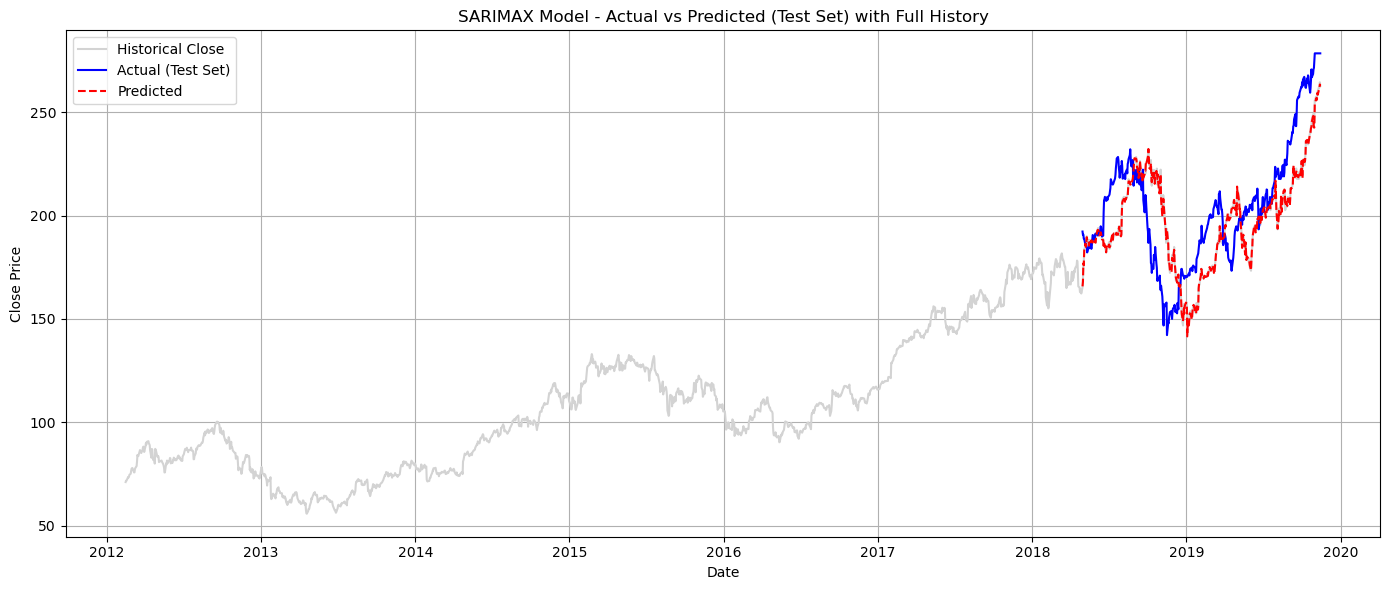

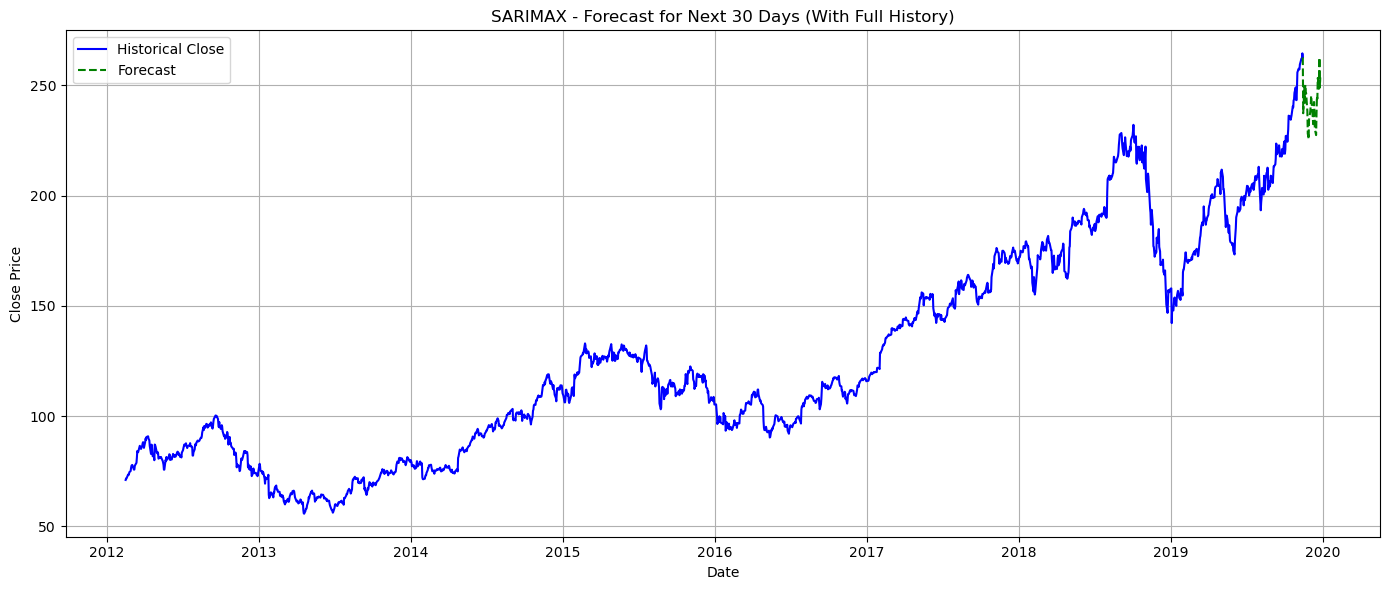

In [25]:
# --- 15.1 Original vs Predicted on Test Set (Full History Context) ---
plt.figure(figsize=(14, 6))

# Plot full historical actual Close prices
plt.plot(df.index, df['Close'], label='Historical Close', color='lightgray')

# Overlay test set actual values in blue for clarity
plt.plot(y_test.index, y_test, label='Actual (Test Set)', color='blue')

# Plot predicted values from best model in red dashed line
if best_model_name == "XGBoost":
    plt.plot(y_test.index, xgb_preds, label='Predicted', color='red', linestyle='--')
elif best_model_name == "SARIMAX":
    plt.plot(test_close.index, sarimax_preds, label='Predicted', color='red', linestyle='--')
else:
    plt.plot(test_close.index, arima_preds, label='Predicted', color='red', linestyle='--')

# Chart aesthetics
plt.title(f"{best_model_name} Model - Actual vs Predicted (Test Set) with Full History")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 15.2 Extended Forecast Plot with Full History and Connected Forecast ---
plt.figure(figsize=(14, 6))

# Plot the full historical data
plt.plot(df.index, df['Close'], label='Historical Close', color='blue')

# Create future date index starting from the last date in df
future_dates = pd.date_range(df.index[-1], periods=n_future+1, freq='B')[1:]

# Combine last known close with forecast for a connected line
last_close = df['Close'].iloc[-1]
connected_preds = pd.Series([last_close] + list(future_preds), index=pd.date_range(df.index[-1], periods=n_future+1, freq='B'))

# Plot the forecast with a dashed green line, starting from the last known point
plt.plot(connected_preds.index, connected_preds.values, label='Forecast', color='green', linestyle='--')

# Add titles and labels
plt.title(f"{best_model_name} - Forecast for Next {n_future} Days (With Full History)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!streamlit run app.py